In [1]:
%run ../talktools.py

<div class="alert alert-info">sklearn is not build for deep/complex networks such as required in covnets (see below). We must go to specialized software (and potentially specialized hardware)</div>

# Deep Learning Frameworks

Almost all frameworks written in low-level C++/C with Python (or other scripting bindings)

### Low-level frameworks

   - Tensorflow (Google) Nov 2015
   - Theano
   - Caffe (Berkeley)
   - Torch (Lua)
   - pytorch (Python)
   - CNTK (Microsoft)
   - Chainer
   - PaddlePaddle (Baidu) Aug 2016
   
### High level frameworks (Python)

   - Keras (atop Tensorflow, Theano)
   - TFLearn 
   - nolearn
   - SkFlow (part of tensorflow)
   - [Lasagne](http://lasagne.readthedocs.io/en/latest/index.html) (atop Theano)
   
<img src="https://pbs.twimg.com/media/DX0lfBNU8AEs8KG.png:large" width="75%">
Source: https://twitter.com/fchollet/status/971863128341323776

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">TensorFlow is the platform of choice for deep learning in the research community. These are deep learning framework mentions on arXiv over the past 3 months <img src="https://pbs.twimg.com/media/DXy_uc0VAAAIhKG.jpg:small">

&mdash; François Chollet (@fchollet) <a href="https://twitter.com/fchollet/status/971863128341323776?ref_src=twsrc%5Etfw">March 8, 2018</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>


see also: https://github.com/mbadry1/Top-Deep-Learning

In [82]:
# load the data from before
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
df = pd.read_csv("galspec.csv")
X = df[['dered_r', 'ug_color', 'gr_color', 'ri_color', 'iz_color', 'modelMagErr_u',
       'modelMagErr_g', 'modelMagErr_r', 'modelMagErr_i', 'modelMagErr_z',
       'fiberMag_r', 'fiber_ug', 'fiber_gr', 'fiber_ri', 'fiber_iz']]
y = df[["specz"]]
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42, shuffle=True)

pt = preprocessing.PowerTransformer()  # this serves to rescale (non-linearly) the data so that it is roughly Gaussian
X_train_scaled = pt.fit_transform(X_train)
X_test_scaled = pt.transform(X_test)

In [83]:
# Import TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential  # linear stack of layers
from keras.layers import Dense, Activation

# Print TensorFlow version
print(tf.__version__)

1.9.0


See https://keras.io/getting-started/sequential-model-guide/

In [84]:
def nn_clf():
    model = Sequential()
    model.add(Dense(10, input_shape=(15,), activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(10,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(5,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(1, activation="relu", kernel_initializer='random_uniform'))
    model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae',"mse"])
    return model

In [85]:
nn_clf().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_47 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_48 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 6         
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [86]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold

clf = KerasRegressor(build_fn=nn_clf, batch_size=32, epochs=50)
clf.fit(X_train_scaled, y_train)

Epoch 1/50
3350/3350 [==============================] - 1s 401us/step - loss: 0.0850 - mean_absolute_error: 0.2444 - mean_squared_error: 0.0850
Epoch 2/50
3350/3350 [==============================] - 0s 77us/step - loss: 0.0054 - mean_absolute_error: 0.0553 - mean_squared_error: 0.0054
Epoch 3/50
3350/3350 [==============================] - 0s 69us/step - loss: 0.0037 - mean_absolute_error: 0.0445 - mean_squared_error: 0.0037
Epoch 4/50
3350/3350 [==============================] - 0s 87us/step - loss: 0.0031 - mean_absolute_error: 0.0398 - mean_squared_error: 0.0031
Epoch 5/50
3350/3350 [==============================] - 0s 98us/step - loss: 0.0028 - mean_absolute_error: 0.0373 - mean_squared_error: 0.0028
Epoch 6/50
3350/3350 [==============================] - 0s 77us/step - loss: 0.0026 - mean_absolute_error: 0.0346 - mean_squared_error: 0.0026
Epoch 7/50
3350/3350 [==============================] - 0s 81us/step - loss: 0.0024 - mean_absolute_error: 0.0324 - mean_squared_error: 0.002

MSE 0.04997122426845516


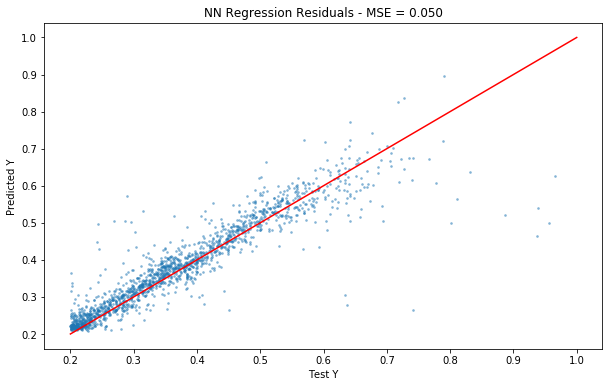

In [87]:
# how well did we do?
import numpy as np
from sklearn.metrics import mean_squared_error
mse = np.sqrt(mean_squared_error(y_test, clf.predict(X_test_scaled))) ; print("MSE",mse)

plt.figure(figsize=(10,6))
plt.title("NN Regression Residuals - MSE = %.3f" % mse)
plt.scatter(y_test,clf.predict(X_test_scaled),alpha=0.4,s=3)
plt.xlabel("Test Y")
plt.ylabel("Predicted Y")
plt.plot([0.2,1],[0.2,1.0],c="r")

Maybe we also want to predict the error in the photometric redshift. So we can try to predict 2 outputs.

In [148]:
def nn_clf_two():
    model = Sequential()
    model.add(Dense(15, input_shape=(15,), activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(12,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(10,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(5,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(2, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae',"mse"])
    return model

In [149]:
nn_clf_two().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_117 (Dense)            (None, 12)                192       
_________________________________________________________________
dense_118 (Dense)            (None, 10)                130       
_________________________________________________________________
dense_119 (Dense)            (None, 5)                 55        
_________________________________________________________________
dense_120 (Dense)            (None, 2)                 12        
Total params: 629
Trainable params: 629
Non-trainable params: 0
_________________________________________________________________


In [150]:
y = df[["specz", "speczerr"]]
y

,specz,speczerr
0,0.250500,0.000046
1,0.268236,0.000052
2,0.355940,0.000091
3,0.235981,0.000063
4,0.212389,0.000032
5,0.416048,0.000122
6,0.320334,0.000106
7,0.212348,0.000012
8,0.493088,0.000177
9,0.966360,0.000060


The scales of the outputs are very different. Let's rescale them.

In [151]:
from sklearn.preprocessing import RobustScaler

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42, shuffle=True)

pt = preprocessing.PowerTransformer()  # this serves to rescale (non-linearly) the data so that it is roughly Gaussian
X_train_scaled = pt.fit_transform(X_train)
X_test_scaled = pt.transform(X_test)

pty = RobustScaler()
pty.fit(y_train)
y_train_scaled = pty.transform(y_train)
y_test_scaled = pty.transform(y_test)

In [152]:
clf = KerasRegressor(build_fn=nn_clf_two, batch_size=64, epochs=100)
clf.fit(X_train_scaled, y_train_scaled)

Epoch 1/100
3350/3350 [==============================] - 2s 516us/step - loss: 183.3709 - mean_absolute_error: 0.7275 - mean_squared_error: 183.3709
Epoch 2/100
3350/3350 [==============================] - 0s 46us/step - loss: 183.2998 - mean_absolute_error: 0.6885 - mean_squared_error: 183.2998
Epoch 3/100
3350/3350 [==============================] - 0s 44us/step - loss: 183.0255 - mean_absolute_error: 0.5690 - mean_squared_error: 183.0255
Epoch 4/100
3350/3350 [==============================] - 0s 48us/step - loss: 182.9263 - mean_absolute_error: 0.5488 - mean_squared_error: 182.9263
Epoch 5/100
3350/3350 [==============================] - 0s 43us/step - loss: 182.8286 - mean_absolute_error: 0.5461 - mean_squared_error: 182.8286
Epoch 6/100
3350/3350 [==============================] - 0s 47us/step - loss: 182.6976 - mean_absolute_error: 0.5442 - mean_squared_error: 182.6976
Epoch 7/100
3350/3350 [==============================] - 0s 49us/step - loss: 182.5270 - mean_absolute_error: 0

3350/3350 [==============================] - 0s 50us/step - loss: 8.4865 - mean_absolute_error: 0.6149 - mean_squared_error: 8.4865
Epoch 57/100
3350/3350 [==============================] - 0s 54us/step - loss: 7.2172 - mean_absolute_error: 0.6105 - mean_squared_error: 7.2172
Epoch 58/100
3350/3350 [==============================] - 0s 48us/step - loss: 5.9028 - mean_absolute_error: 0.6070 - mean_squared_error: 5.9028
Epoch 59/100
3350/3350 [==============================] - 0s 44us/step - loss: 5.1558 - mean_absolute_error: 0.6037 - mean_squared_error: 5.1558
Epoch 60/100
3350/3350 [==============================] - 0s 47us/step - loss: 4.2254 - mean_absolute_error: 0.5999 - mean_squared_error: 4.2254
Epoch 61/100
3350/3350 [==============================] - 0s 58us/step - loss: 3.4804 - mean_absolute_error: 0.5965 - mean_squared_error: 3.4804
Epoch 62/100
3350/3350 [==============================] - 0s 57us/step - loss: 2.9809 - mean_absolute_error: 0.5941 - mean_squared_error: 2.980

In [153]:
clf.predict(X_test_scaled)

array([[0.09031491, 0.13611746],
       [0.09031491, 0.13611746],
       [0.09031491, 0.13611746],
       ...,
       [0.09031491, 0.13611746],
       [0.09031491, 0.13611746],
       [0.09031491, 0.13611746]], dtype=float32)

(-1, 5)

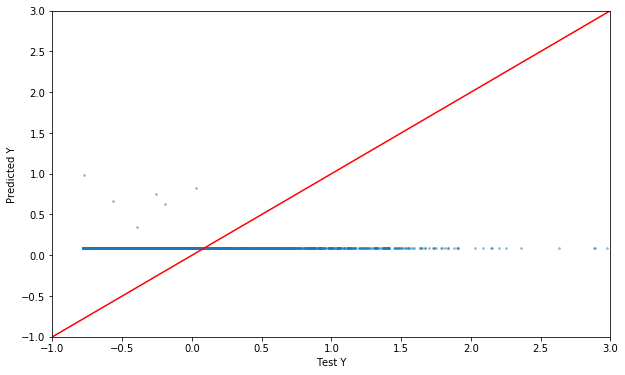

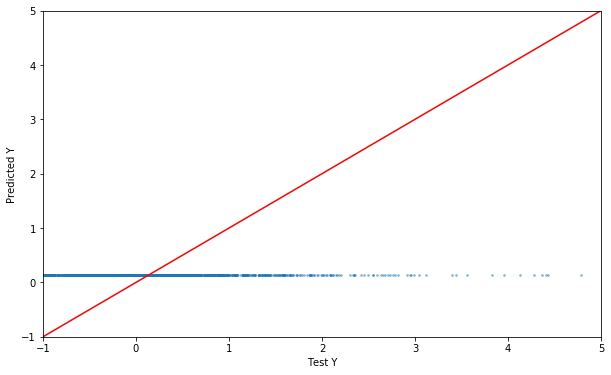

In [154]:
# how well did we do?
import numpy as np
from sklearn.metrics import mean_squared_error
#mse = np.sqrt(mean_squared_error(y_test, clf.predict(X_test_scaled))) ; print("MSE",mse)

plt.figure(figsize=(10,6))
#plt.title("NN Regression Residuals - MSE = %.3f" % mse)
plt.scatter(y_test_scaled[:,0], clf.predict(X_test_scaled)[:,0],alpha=0.4,s=3)
plt.xlabel("Test Y")
plt.ylabel("Predicted Y")
plt.plot([-1,3],[-1,3],c="r")
plt.xlim(-1,3)
plt.ylim(-1,3)

plt.figure(figsize=(10,6))
#plt.title("NN Regression Residuals - MSE = %.3f" % mse)
plt.scatter(y_test_scaled[:,1], clf.predict(X_test_scaled)[:,1],alpha=0.4,s=3)
plt.xlabel("Test Y")
plt.ylabel("Predicted Y")
plt.plot([-1,5],[-1,5],c="r")
plt.xlim(-1,5)
plt.ylim(-1,5)


(0.0, 1.0)

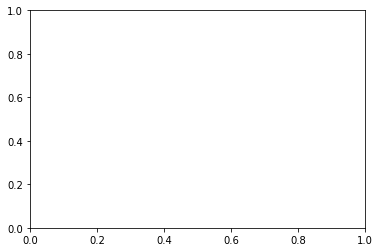

In [103]:
 clf.predict(X_test_scaled)[:,0].shape

(1650,)

In [105]:
y_test_scaled.scale

AttributeError: 'numpy.ndarray' object has no attribute 'scale'

<img src="http://www.asimovinstitute.org/wp-content/uploads/2016/09/neuralnetworks.png">

Source: http://www.asimovinstitute.org/neural-network-zoo/

## Convolutional Neural Nets (ConvNets)

NNs built for images (or more generally, inputs with structure). **These may be useful for Lab #2**

### Key Ideas: 
  - layers see only parts of each image (effectively all other weights are zero).
  - some layers do simple operations on previous layers to reduce dimensionality (e.g., take the largest value in a a 3x3 range)
  - "Every Layer has a simple API: It transforms an input 3D volume to an output 3D volume with some differentiable function that may or may not have parameters."
 
<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg">

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg">

"An example input volume in red (e.g. a 32x32x3 CIFAR-10 image), and an example volume of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (i.e. all color channels). Note, there are multiple neurons (5 in this example) along the depth, all looking at the same region in the input - see discussion of depth columns in text below. "

cf. http://cs231n.github.io/convolutional-networks/

<img src="http://www.nature.com/nature/journal/v521/n7553/images/nature14539-f2.jpg">
Source: http://www.nature.com/nature/journal/v521/n7553/fig_tab/nature14539_F2.html

### Pooling

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" width="40%">
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width="40%">
Source: http://cs231n.github.io/convolutional-networks/